In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#plt.rcParams['figure.dpi'] = 150
import glob, os, json

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

import scipy.stats as st
import timeit
import pickle

# Download HMMER data from the 5 batch jobs using the `03_download_hmmer.py` script

```console
python3 03_download_hmmer.py Data/PFAM_1 498 "https://www.ebi.ac.uk/Tools/hmmer/download/C89D6018-CF04-11EC-9B2E-CE02DCC3747A."

python3 03_download_hmmer.py Data/PFAM_2 499 "https://www.ebi.ac.uk/Tools/hmmer/download/0FA10BC6-CF06-11EC-B9A1-9E64E976C163."

python3 03_download_hmmer.py Data/PFAM_3 498 "https://www.ebi.ac.uk/Tools/hmmer/download/1E071650-CF07-11EC-8237-159953F04F9B."

python3 03_download_hmmer.py Data/PFAM_4 500 "https://www.ebi.ac.uk/Tools/hmmer/download/8EA0FB46-CF08-11EC-8CCE-9F64E976C163."

python3 03_download_hmmer.py Data/PFAM_5 137 "https://www.ebi.ac.uk/Tools/hmmer/download/15B613C2-CF0A-11EC-B9ED-F99853F04F9B."
```

# Combine HMMER data for each protein in a batch using `04_process_hmmer.py`

```console
python3 04_process_hmmer.py Data/PFAM_1 Data/proteins_seq_small_1.fasta Data/batch_1

python3 04_process_hmmer.py Data/PFAM_2 Data/proteins_seq_small_2.fasta Data/batch_2

python3 04_process_hmmer.py Data/PFAM_3 Data/proteins_seq_small_3.fasta Data/batch_3

python3 04_process_hmmer.py Data/PFAM_4 Data/proteins_seq_small_4.fasta Data/batch_4

python3 04_process_hmmer.py Data/PFAM_5 Data/proteins_seq_small_5.fasta Data/batch_5
```

# 7 Proteins longer than 5000 had to be queried using their UniProt ID

## Following esults determined manually

Q63HN8: 1 zf-C3HC4, 1 DUF6539

Q09666: 0 (only disordered and low complexity regions)

Q9NU22: 8 AAA_5, 3 AAA_lid_7, 1 AAA_lid_5

P58107: 36 Plectin

Q03001: 2 CH, 20 Spectrin, 1 SH3_10, 1 Spectrin_like, 1 Plectin, 1 EF-hand_7, 1 GAS2

Q86UQ4: 2 ABC2_membrane_3, 2 ABC_tran

Q8NF91: 2 CH, 10 Spectrin, 1 KASH

<b>If a results file is not present in the expected directory, it means that no domains were found.</b>

## Encode them in dataframes as follows (done already and combined with the main dataframe):

In [2]:
# df_1 = pd.DataFrame({'UniProt': ['Q63HN8', 'Q63HN8'], 'PFAM': ['zf-C3HC4', 'DUF6539'], 'Count': [1, 1]})

# df_2 = pd.DataFrame({'UniProt': ['Q9NU22', 'Q9NU22', 'Q9NU22'], 'PFAM': ['AAA_5', 'AAA_lid_7', 'AAA_lid_5'], 'Count': [8, 3, 1]})

# df_3 = pd.DataFrame({'UniProt': ['P58107'], 'PFAM': ['Plectin'], 'Count': [36]})

# df_4 = pd.DataFrame({'UniProt': ['Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001'], 'PFAM': ['CH', 'Spectrin', 'SH3_10', 'Spectrin_like', 'Plectin', 'EF-hand_7', 'GAS2'], 'Count': [2, 20, 1, 1, 1, 1, 1]})

# df_5 = pd.DataFrame({'UniProt': ['Q86UQ4', 'Q86UQ4'], 'PFAM': ['ABC2_membrane_3', 'ABC_tran'], 'Count': [2, 2]})

# df_6 = pd.DataFrame({'UniProt': ['Q8NF91', 'Q8NF91', 'Q8NF91'], 'PFAM': ['CH', 'Spectrin', 'KASH'], 'Count': [2, 10, 1]})

# files = glob.glob("../Data/batch_*.csv")
# dfs_lst = [pd.read_csv(f) for f in files]

# final = pd.concat([pd.concat(dfs_lst), df_1, df_2, df_3, df_4, df_5, df_6])

# final.to_csv("../Processed/protein_domains.csv", index=False)

In [3]:
df = pd.read_csv("../Processed/protein_domains.csv")
print(df.shape)
print(f"{len(df.UniProt.unique())} proteins")

(5165, 3)
2081 proteins


# Distribution of Protein Domains in the dataset

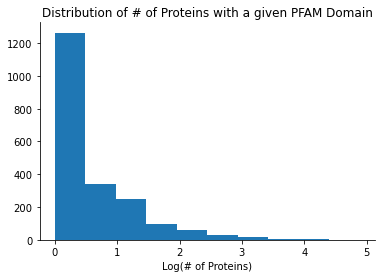

In [4]:
# count the number of proteins containing a given domain
summary_df = pd.DataFrame(df.groupby("PFAM")["UniProt"].count()).sort_values("UniProt", ascending=False).reset_index()
plt.hist(np.log(summary_df["UniProt"]))

plt.title("Distribution of # of Proteins with a given PFAM Domain")
plt.xlabel("Log(# of Proteins)")
sns.despine()
plt.show()

# Unsupervised Methods

## Principal Components Analysis -- not very informative b/c of such low explained variance and poor clustering

### No significant Spearman correlations between domains and PCs

### Was trying to see if proteins with shared GO functions would cluster together in protein domain space

### Kind of suggestive that's a very weak correlation between sharing GO functions and protein domains

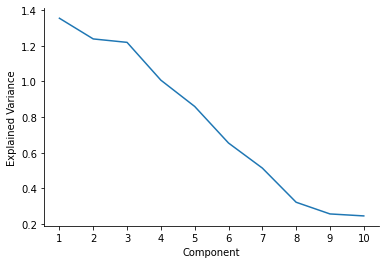

In [5]:
# first check using the elbow method
n = 10

# use the whole matrix for now
data = df.pivot(index="UniProt", columns="PFAM", values="Count").fillna(0).astype(int)

pca_large = PCA(n_components=n).fit(data.values)

plt.plot(np.arange(1, n+1), pca_large.explained_variance_)
sns.despine()
plt.xticks(np.arange(1, n+1))
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.show()

In [6]:
# check that no proteins or domains have 0 representation
sum(data.sum(axis=1)==0), sum(data.sum(axis=1)==0)

(0, 0)

Explained variances: [1.35499293 1.23873102]


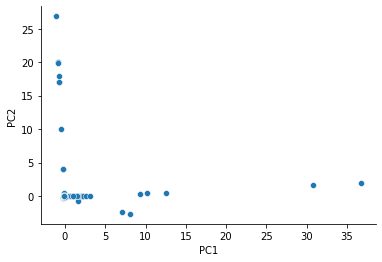

In [7]:
# dbscan = DBSCAN(min_samples=3).fit(matrix_domains_high.values)
# print(f"{np.max(dbscan.labels_)+1} clusters found")

pca = PCA(n_components=2).fit(data.values)

print(f"Explained variances: {pca.explained_variance_}")

pca_transformed = pca.transform(data.values)

pca_df = pd.DataFrame(pca_transformed)

pca_df.columns = ["PC1", "PC2"]

pca_df["UniProt"] = data.index

# -1 cluster means too disordered
#pca_df["Cluster"] = dbscan.labels_

sns.scatterplot(data=pca_df, x="PC1", y="PC2", 
                #hue="Cluster", 
                #palette="viridis"
               )
sns.despine()
plt.show()

In [8]:
spearman_res_1 = [[data.columns[i], st.spearmanr(pca_df.PC1, data.iloc[:, i])] for i in range(n)]

for domain, res in spearman_res_1:
    
    if res[1] < 0.05:
        print(domain, res[0])

In [9]:
spearman_res_2 = [[data.columns[i], st.spearmanr(pca_df.PC2, data.iloc[:, i])] for i in range(n)]

for domain, res in spearman_res_2:
    
    if res[1] < 0.05:
        print(domain, res[0])

# Number of proteins associated with each GO annotation

In [10]:
GO_proteins = pd.read_csv("../Processed/enriched_GO_proteins.csv")

# number of proteins that each GO is associated with
summary_go_df = pd.DataFrame(GO_proteins.groupby("GO")["Gene"].count()).reset_index().sort_values("Gene", ascending=False).reset_index(drop=True)
summary_go_df.columns = ["GO", "num_proteins"]

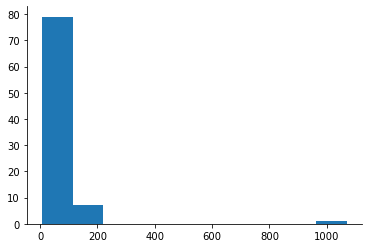

In [11]:
plt.hist(summary_go_df.num_proteins.values)
sns.despine()
plt.show()

In [12]:
# these are the 2229 proteins that were queried on PFAM for their domain
GO_distances = pd.read_csv("../Processed/GO_distances.csv.gz", compression="gzip")

In [13]:
GO_distances.shape

(663724, 6)

## For each pair in the above dataframe, compute how many PFAM domains they share

The next cell takes 5-6 minutes to run

In [14]:
# start = timeit.default_timer()

# # this returns the number of rows containing the same PFAM --> means that they have the same domain
# pfam_pairwise_share = [sum(df.loc[df.UniProt.isin([row["uniprot_1"],  row["uniprot_2"]])].duplicated("PFAM")) for _, row in GO_distances.iterrows()]

# end = timeit.default_timer()
# print(f"{end-start} seconds")

# # save this for later because it takes a few minutes to run
# with open("../Processed/pfam_pairwise_share", "wb") as file:
#     pickle.dump(pfam_pairwise_share, file, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
with open('../Processed/pfam_pairwise_share', 'rb') as file:
    pfam_pairwise_share = pickle.load(file)

In [16]:
print(np.mean(pfam_pairwise_share), np.median(pfam_pairwise_share), np.max(pfam_pairwise_share))

0.03525561829917255 0.0 13


In [17]:
len(pfam_pairwise_share), len(GO_distances)

(663724, 663724)

# See if proteins that share PFAM domains share GO functions

Correlate only protein pairs that share at least 1 PFAM domain and 1 GO function (GO function filtering already done)

In [18]:
GO_distances["PFAM_share"] = pfam_pairwise_share

In [19]:
df_plot = GO_distances.loc[(GO_distances["num_GO_overlap"]>0) & (GO_distances["PFAM_share"]>0)].reset_index(drop=True)

In [20]:
df_plot

,gene_1,gene_2,Jaccard,num_GO_overlap,uniprot_1,uniprot_2,PFAM_share
0,A1CF,ALYREF,0.333333,1,Q9NQ94,Q86V81,1
1,A1CF,BOLL,0.500000,2,Q9NQ94,F8WD91,1
2,A1CF,CELF1,0.500000,2,Q9NQ94,Q92879,1
3,A1CF,CIRBP,0.400000,2,Q9NQ94,Q14011,1
4,A1CF,CPEB4,0.285714,2,Q9NQ94,Q17RY0,1
...,...,...,...,...,...,...,...
17027,ZNF579,ZNF74,1.000000,1,Q8NAF0,Q16587,1
17028,ZNF579,ZNF768,1.000000,1,Q8NAF0,Q9H5H4,2
17029,ZNF622,ZNF638,1.000000,1,Q969S3,Q14966,1
17030,ZNF622,ZNF768,1.000000,1,Q969S3,Q9H5H4,1


In [21]:
test_val = st.spearmanr(df_plot.PFAM_share, df_plot.num_GO_overlap)
test_val

SpearmanrResult(correlation=0.3022777644336635, pvalue=0.0)

### Permutation test for the correlation coefficient (bootstrapping like for what `scipy` computes itself)

p-value = proportion of permutations with an absolute value of the correlation at least as large as the observed one.

In [22]:
#0.2-0.25 seconds to run one iteration

def shuffle_spearman(data_1, data_2):
    
    # keep one array fixed, shuffle the other one
    data_2_shuffled = np.random.permutation(data_2)
    
    # compute the correlation coefficient
    return st.spearmanr(data_1, data_2_shuffled)[0]

In [23]:
# should take 3 minutes and 20 seconds to run
shuffled_corrs = [shuffle_spearman(df_plot.PFAM_share, df_plot.num_GO_overlap) for _ in range(10000)]

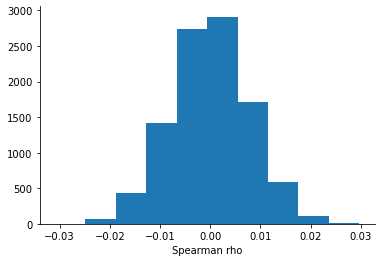

In [24]:
# cool, so it is significant
plt.hist(shuffled_corrs)
sns.despine()
#plt.axvline(test_val[0], color="purple")
plt.xlabel("Spearman rho")
plt.show()

In [25]:
# significant because the sample size is so large. But at least the correlation coefficient is not that close to 0
p_val = np.sum(np.abs(shuffled_corrs) > np.abs(test_val[0])) / len(shuffled_corrs)
p_val

0.0